## Inteligência Artificial 2024.1: Prova N1 - 1o Bimestre

### Nome: Carlos Eduardo Vieira Santos

### R.A.: 081200016

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.typing import NDArray

## Base de dados:

#### Carregamento dos dados:

In [2]:
base = pd.read_excel("Base_N1_B1_2024.1.xlsx")
base.head()

,Feature1,Feature2,Label
0,0.000,5.472986,Red
1,0.005,4.326074,Red
2,0.010,5.257439,Red
3,0.015,3.321764,Red
4,0.020,5.783143,Red


In [3]:
base.describe()

,Feature1,Feature2
count,800.000000,800.000000
mean,1.072500,3.588866
std,0.582564,3.133176
min,0.000000,-3.353179
25%,0.573750,0.712466
50%,1.072500,3.553948
75%,1.571250,6.438598
max,2.145000,9.963324


In [4]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  800 non-null    float64
 1   Feature2  800 non-null    float64
 2   Label     800 non-null    object 
dtypes: float64(2), object(1)
memory usage: 18.9+ KB


In [5]:
base["Label"].value_counts()

Red     400
Blue    400
Name: Label, dtype: int64

In [6]:
base["Bias"] = 1
df_red = base.loc[base["Label"] == "Red", ["Bias", "Feature1", "Feature2"]].copy()
df_blue = base.loc[base["Label"] == "Blue", ["Bias", "Feature1", "Feature2"]].copy()

#### Distribuição dos dados:

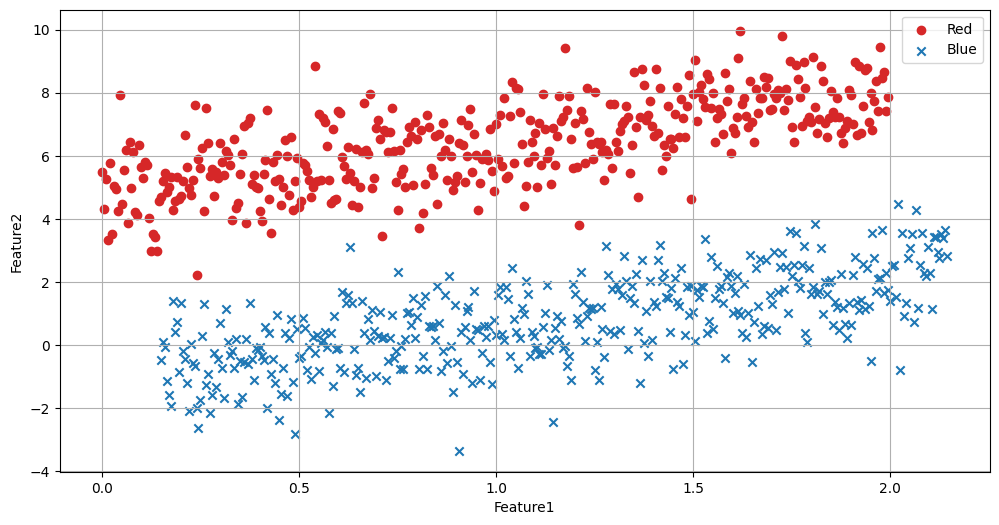

In [39]:
plt.figure(figsize=(12, 6))
plt.scatter(
    df_red["Feature1"], df_red["Feature2"], marker="o", color="tab:red", label="Red"
)
plt.scatter(
    df_blue["Feature1"], df_blue["Feature2"], marker="x", color="tab:blue", label="Blue"
)
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.grid()
plt.legend()
plt.show()

## Desenvolvimento do classificador:

#### Classe genérica com funções úteis:

In [8]:
class Classifier:
    """Machine Learning model best suited for solving classification problems."""

    def __init__(self):
        self._misclassifications: list[int] = []
        self._weights: NDArray = None

    def plot_misclassifications(self, start_index: int = 0, end_index: int = -1):
        # recalcula índices caso sejam negativos
        epochs: NDArray = np.arange(1, len(self._misclassifications) + 1)[
            start_index:end_index
        ]
        misclassifications = self._misclassifications[start_index:end_index]

        plt.plot(epochs, misclassifications)
        plt.xlabel("Epoch")
        plt.ylabel("Number of Misclassified Points")
        plt.grid()
        plt.show()

    def generate_decision_boundary(self, x_values: NDArray) -> NDArray:
        # foi dado o valor de x1, e se deseja descobrir o valor de x2
        # considerando x0 = 1, e os pesos dados pelo algoritmo:
        #
        # w0x0 + w1x1 + w2x2 = 0
        # -w2x2 = w0x0 + w1x1
        # w2x2 = -(w0x0 + w1x1)
        # w2x2 = -(w0 + w1x1)
        # x2 = -(w0 + w1x1) / w2
        return (
            -(self._weights[0, 0] + self._weights[0, 1] * x_values)
            / self._weights[0, 2]
        )

    def get_weights(self, as_dataframe: bool = False) -> NDArray | pd.DataFrame:
        if as_dataframe:
            weights = self._weights.flatten()
            return pd.DataFrame(
                {"weight": [f"w{i}" for i in range(len(weights))], "value": weights}
            )

        return self._weights

    def predict(X: NDArray) -> NDArray:
        raise NotImplementedError()

#### Classificador Perceptron

In [9]:
class PerceptronClassifier(Classifier):
    """Machine Learning model that uses Perceptron algorithm to solve classification problems."""

    def __init__(self, max_iterations: int = 1000, learning_rate: float = 1e-4):
        super().__init__()

        self.max_iterations: int = max_iterations
        self.learning_rate: float = learning_rate

    def fit(self, features: NDArray, labels: NDArray):
        # inicializa pesos
        n_of_weights: int = features.shape[1]
        w: NDArray = np.random.randn(n_of_weights).reshape(1, n_of_weights)

        # reseta classificações incorretas
        self._misclassifications = []

        for _ in range(self.max_iterations):
            n_of_misclassified: int = 0
            weight_changes: list[float] = []

            for x, expected_y in zip(features, labels):
                predicted_y: int = 1 if np.dot(w, x.transpose()) > 0 else 0

                delta: int = expected_y - predicted_y

                if delta:
                    n_of_misclassified += 1
                    weight_change: float = delta * x * self.learning_rate
                    weight_changes.append(weight_change)

                    w += weight_change
            self._misclassifications.append(n_of_misclassified)

            if n_of_misclassified == 0:
                # se não houver mais nenhum erro, encerra as iterações
                break

        self._weights = w

    def predict(self, X: NDArray) -> NDArray:
        return np.where(np.dot(X, self._weights.transpose()) > 0, 1, 0)

#### Funções auxiliares do classificador:

In [10]:
# mapeamento de dummies
labels_to_dummies = {"Red": 0, "Blue": 1}
dummies_to_labels = {v: k for k, v in labels_to_dummies.items()}

In [11]:
def build_train_and_test_dataframes(
    X_train: NDArray, y_train: NDArray, X_test: NDArray, y_test: NDArray
) -> tuple[pd.DataFrame, pd.DataFrame]:
    cols: list[str] = ["Bias", "Feature1", "Feature2"]

    df_train = pd.DataFrame(X_train, columns=cols)
    df_train["Expected"] = y_train
    df_train["Label"] = df_train["Expected"].map(dummies_to_labels)

    df_test = pd.DataFrame(X_test, columns=cols)
    df_test["Expected"] = y_test
    df_test["Label"] = df_test["Expected"].map(dummies_to_labels)

    return df_train, df_test

In [12]:
def split_by_color(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_red = df.loc[df["Label"] == "Red"]
    df_blue = df.loc[df["Label"] == "Blue"]

    return df_red, df_blue

In [13]:
def split_correct_and_incorrect(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_correct = df.loc[df["Expected"] == df["Predicted"]]
    df_incorrect = df.loc[df["Expected"] != df["Predicted"]]

    return df_correct, df_incorrect

In [14]:
def calculate_accuracy(n_of_correct_cases: int, dataset_size: int):
    return 100 * n_of_correct_cases / dataset_size

In [15]:
def plot_confusion_matrix(
    true_positive: int,
    false_positive: int,
    true_negative: int,
    false_negative: int,
    class_names: list[str],
):
    confusion_matrix = np.array(
        [[true_positive, false_positive], [false_negative, true_negative]]
    )

    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap="Blues", interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(confusion_matrix.shape[0]),
        yticks=np.arange(confusion_matrix.shape[1]),
        xticklabels=class_names,
        yticklabels=class_names,
        title="Confusion Matrix",
        xlabel="Real",
        ylabel="Predicted",
    )

    class_1, class_2 = class_names
    cm_labels = [
        [f"True {class_1}", f"False {class_1}"],
        [f"False {class_2}", f"True {class_2}"],
    ]

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            quadrant_text = f"{cm_labels[i][j]}\n{confusion_matrix[i][j]}"
            quadrant_color = "white" if (i + j) % 2 == 0 else "black"
            ax.text(j, i, quadrant_text, ha="center", va="center", color=quadrant_color)
            
    plt.show()

In [41]:
def plot_classifier_stats(
    classifier: Classifier,
    X_train: NDArray,
    y_train: NDArray,
    X_test: NDArray,
    y_test: NDArray,
):
    df_train, df_test = build_train_and_test_dataframes(
        X_train, y_train, X_test, y_test
    )
    df_test["Predicted"] = classifier.predict(X_test)

    df_red_train, df_blue_train = split_by_color(df_train)
    df_red_test, df_blue_test = split_by_color(df_test)

    df_red_correct, df_red_incorrect = split_correct_and_incorrect(df_red_test)
    df_blue_correct, df_blue_incorrect = split_correct_and_incorrect(df_blue_test)

    x_values = np.linspace(
        np.min(df_test["Feature1"]), np.max(df_test["Feature1"]), 100
    )
    y_values = classifier.generate_decision_boundary(x_values)

    plt.subplots(figsize=(18, 6))

    plt.subplot(1, 2, 1)

    plt.title("Train Dataset")

    plt.scatter(
        df_red_train["Feature1"],
        df_red_train["Feature2"],
        marker="o",
        color="tab:red",
        label="Red",
    )

    plt.scatter(
        df_blue_train["Feature1"],
        df_blue_train["Feature2"],
        marker="x",
        color="tab:blue",
        label="Blue",
    )

    plt.plot(x_values, y_values, label="Classifier", color="black")
    plt.grid()
    plt.legend()
    plt.xlabel("Feature1")
    plt.ylabel("Feature2")

    plt.subplot(1, 2, 2)

    plt.title("Test Dataset")

    plt.scatter(
        df_red_correct["Feature1"],
        df_red_correct["Feature2"],
        marker="o",
        color="tab:green",
        label="Correct (Red)",
    )
    plt.scatter(
        df_red_incorrect["Feature1"],
        df_red_incorrect["Feature2"],
        marker="o",
        color="tab:red",
        label="Incorrect (Red)",
    )

    plt.scatter(
        df_blue_correct["Feature1"],
        df_blue_correct["Feature2"],
        marker="x",
        color="tab:green",
        label="Correct (Blue)",
    )

    plt.scatter(
        df_blue_incorrect["Feature1"],
        df_blue_incorrect["Feature2"],
        marker="x",
        color="tab:red",
        label="Incorrect (Blue)",
    )

    plt.plot(x_values, y_values, label="Classifier", color="black")

    plt.grid()
    plt.legend()
    plt.xlabel("Feature1")
    plt.ylabel("Feature2")

    plt.show()

    true_red = df_red_correct.shape[0]
    true_blue = df_blue_correct.shape[0]

    false_red = df_blue_incorrect.shape[0]
    false_blue = df_red_incorrect.shape[0]

    plot_confusion_matrix(true_red, false_red, true_blue, false_blue, ["Red", "Blue"])

    n_of_misclassified = df_red_incorrect.shape[0] + df_blue_incorrect.shape[0]
    print(f"Número de pontos classificados incorretamente: {n_of_misclassified}")

    n_of_correct_cases = df_red_correct.shape[0] + df_blue_correct.shape[0]
    dataset_size = df_test.shape[0]
    accuracy = calculate_accuracy(n_of_correct_cases, dataset_size)
    print(f"Exatidão: {accuracy}%")

In [17]:
def predict_class(classifier: Classifier, X: NDArray) -> str:
    predicted_class = classifier.predict(X).item(0)
    
    return dummies_to_labels[predicted_class]

#### Definição das variáveis X e Y

In [18]:
labels = base["Label"].map(labels_to_dummies).values
labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [19]:
features = base[["Bias", "Feature1", "Feature2"]].values
features[:10, :]

array([[1.00000000e+00, 0.00000000e+00, 5.47298583e+00],
       [1.00000000e+00, 5.00000000e-03, 4.32607412e+00],
       [1.00000000e+00, 1.00000000e-02, 5.25743950e+00],
       [1.00000000e+00, 1.50000000e-02, 3.32176437e+00],
       [1.00000000e+00, 2.00000000e-02, 5.78314283e+00],
       [1.00000000e+00, 2.50000000e-02, 3.50277866e+00],
       [1.00000000e+00, 3.00000000e-02, 5.05012708e+00],
       [1.00000000e+00, 3.50000000e-02, 4.93227233e+00],
       [1.00000000e+00, 4.00000000e-02, 4.25301812e+00],
       [1.00000000e+00, 4.50000000e-02, 7.93931939e+00]])

In [20]:
# Separa as variáveis em matrizes de teste e de treino
# stratify = parâmetro para manter a proporção das classes em 50/50
# distribuição: treino = 80% / teste = 20%
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=49
)

#### Descida de gradiente utilizando Perceptron

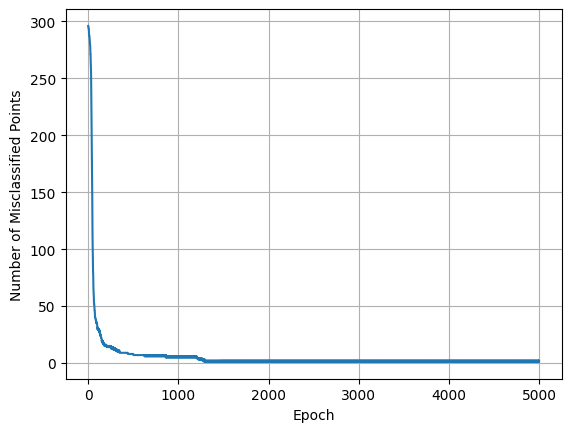

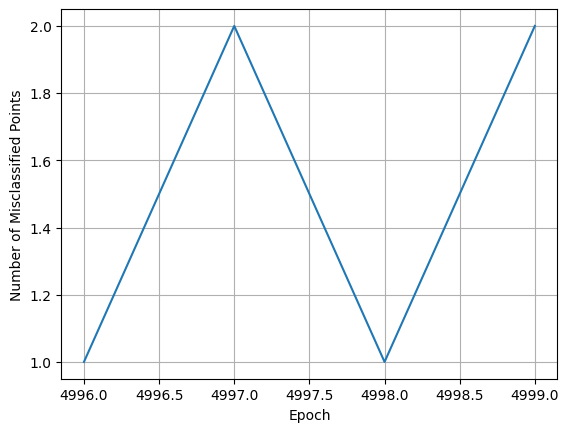

In [25]:
perceptron = PerceptronClassifier(max_iterations=5000)
perceptron.fit(X_train, y_train)
perceptron.plot_misclassifications()

# plota apenas os 5 últimos itens para mostrar se convergiu ou se oscilou
perceptron.plot_misclassifications(start_index=-5)

In [26]:
perceptron.get_weights(as_dataframe=True)

,weight,value
0,w0,0.322272
1,w1,1.153757
2,w2,-0.452390


C:\Users\caduv\AppData\Local\Temp\ipykernel_32688\1838715774.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


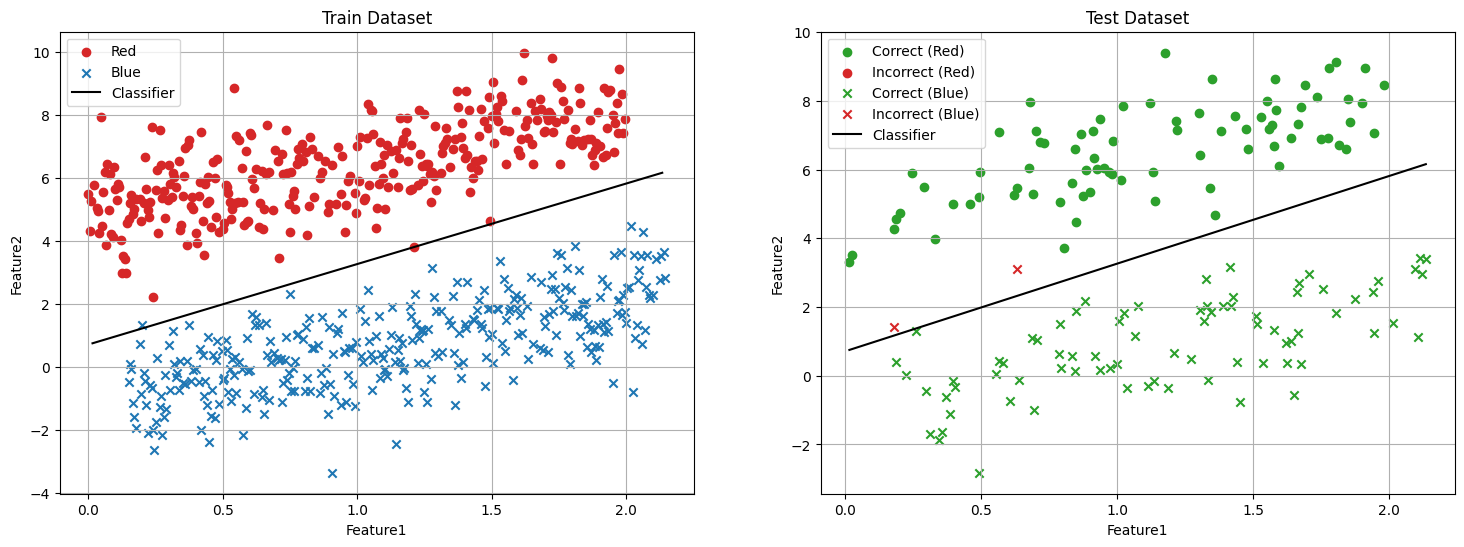

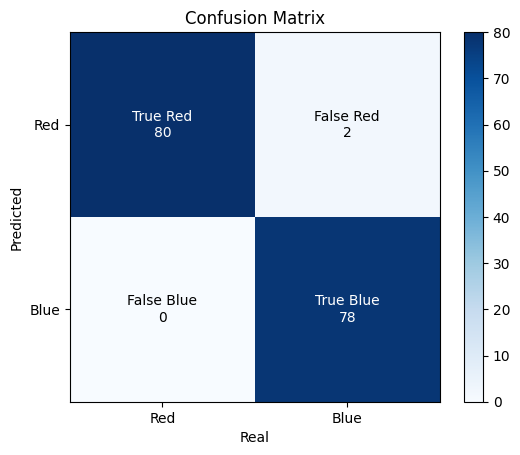

Número de pontos classificados incorretamente: 2
Exatidão: 98.75%


In [42]:
plot_classifier_stats(perceptron, X_train, y_train, X_test, y_test)

#### Exemplo individual

In [29]:
classifier_example = np.array([[1, 34.95, 78.59]])
predict_class(perceptron, classifier_example)

'Blue'

## Desenvolvimento do estimador:

C:\Users\caduv\AppData\Local\Temp\ipykernel_32688\880030122.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


Text(0, 0.5, 'Feature2')

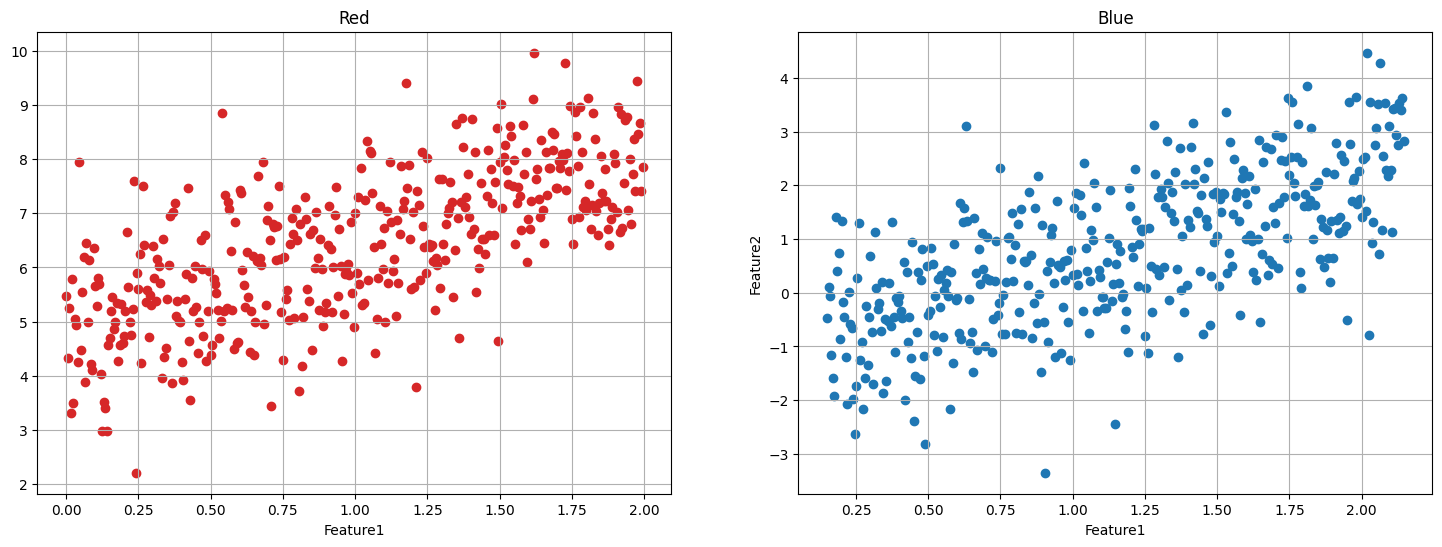

In [48]:
plt.subplots(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_red["Feature1"], df_red["Feature2"], color="tab:red")
plt.title("Red")
plt.grid()
plt.xlabel("Feature1")

plt.subplot(1, 2, 2)
plt.scatter(df_blue["Feature1"], df_blue["Feature2"], color="tab:blue")
plt.title("Blue")
plt.grid()
plt.xlabel("Feature1")
plt.ylabel("Feature2")

In [52]:
red_features = df_red[["Bias", "Feature1"]]
blue_features = df_blue[["Bias", "Feature1"]]

,Bias,Feature1
400,1,0.150
401,1,0.155
402,1,0.160
403,1,0.165
404,1,0.170
...,...,...
795,1,2.125
796,1,2.130
797,1,2.135
798,1,2.140
